# 3 Exploratory Data Analysis<a id='3_Exploratory_Data_Analysis'></a>

## 3.1 Contents<a id='3.1_Contents'></a>
* [3 Exploratory Data Analysis](#3_Exploratory_Data_Analysis)
  * [3.1 Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Imports](#3.3_Imports)
  * [3.4 Load The Data](#3.4_Load_The_Data)
    * [3.4.1 ECG data](#3.4.1_ecg_data)
  * [3.5 Explore The Data](#3.5_Explore_The_Data)
    * [3.5.1 Visualizing High Dimensional Data](#3.5.1_Visualizing_High_Dimensional_Data)
      * [3.5.1.1 Scale the data](#3.5.1.1_Scale_the_data)
      * [3.5.1.2 Verifying the scaling](#3.5.1.2_Verifying_the_scaling)
      * [3.5.1.3 Calculate the PCA transformation](#3.5.1.3_Calculate_the_PCA_transformation)
      * [3.5.1.4 Create a dataset of PCA componenets](#3.5.1.4_Creat_a_dataset_of_PCA)
      * [3.5.3.4 Adding average ticket price to scatter plot](#3.5.3.4_Adding_average_ticket_price_to_scatter_plot)
    * [3.5.2 ECG DataFrame Numeric Data](#3.5.2_DataFrame_Resort_Numeric_Data)
      * [3.5.2.1 Feature correlation heatmap](#3.5.5.2_Feature_correlation_heatmap)
      * [3.5.2.3 Scatterplots of numeric features against ticket price](#3.5.5.3_Scatterplots_of_numeric_features_against_ticket_price)
  


## 3.2 Introduction<a id='3.2_Introduction'></a>

At this point, you should have a firm idea of what your data science problem is and have the data you believe could help solve it. The business problem was a general one of modeling resort revenue. The data you started with contained some ticket price values, but with a number of missing values that led to several rows being dropped completely. You also had two kinds of ticket price. There were also some obvious issues with some of the other features in the data that, for example, led to one column being completely dropped, a data error corrected, and some other rows dropped. You also obtained some additional US state population and size data with which to augment the dataset, which also required some cleaning.

The data science problem you subsequently identified is to predict the adult weekend ticket price for ski resorts.

## 3.3 Imports<a id='3.3_Imports'></a>

In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from library.sb_utils import save_file

## 3.4 Load The Data<a id='3.4_Load_The_Data'></a>

### 3.4.1 ECG data<a id='3.4.1_ecg_data'></a>

In [60]:
ecg_data = pd.read_csv('../data/ecg_data_cleaned.csv')

In [61]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, t0 to Target
dtypes: float64(141)
memory usage: 5.4 MB


In [62]:
ecg_data.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t131,t132,t133,t134,t135,t136,t137,t138,t139,Target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## 3.5 Explore The Data<a id='3.5_Explore_The_Data'></a>

### 3.5.1 Visualizing High Dimensional Data<a id='3.5.1_Visualizing_High_Dimensional_Data'></a>

You may explore features and have found various trends. Some samples are higher in some but not in others. Some features will also be more correlated with one another than others.

One way to disentangle this interconnected web of relationships is via [principle components analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) (PCA). This technique will find linear combinations of the original features that are uncorrelated with one another and order them by the amount of variance they explain. These derived features can be used to visualize the data in a lower dimension (e.g. 2 down from 7) and know how much variance the representation explains. You can also explore how the original features contribute to these derived features.

The basic steps in this process are:

1. scale the data (important here because our features are heterogenous)
2. fit the PCA transformation (learn the transformation from the data)
3. apply the transformation to the data to create the derived features
4. (optionally) use the derived features to look for patterns in the data and explore the coefficients

#### 3.5.1.1 Scale the data<a id='3.5.1.1_Scale_the_data'></a>

You only want numeric data here, although you don't want to lose track of the state labels, so it's convenient to set the state as the index.

In [63]:
#  separate explanatory variables to apply scale on them
ecg_data_scale = scale(ecg_data.iloc[:,0:140])
data_target = ecg_data.iloc[:,-1]

#Create a new dataframe from `ecg_data_scale` using the column names of ecg_data
ecg_data_scaled_df = pd.DataFrame(ecg_data_scale)


# ecg_data_scaled_df = ecg_data_scaled_df.join(data_target)
# ecg_data_scaled_df.columns = ecg_data.columns

ecg_data_scaled_df.head()


,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.130153,-0.814568,-0.924228,-0.944124,-1.094131,-0.671668,0.124996,-0.032972,0.250098,0.696819,...,0.011715,0.513326,0.605224,0.566451,0.527580,0.488543,0.517122,0.412091,0.771724,0.636166
1,-0.727546,-1.623782,-1.293513,-1.064503,-0.773906,-0.406149,0.966096,1.293489,1.028745,1.487142,...,0.353366,0.332585,0.437138,0.561453,0.598203,0.631427,0.637864,0.761909,0.877865,-0.515937
2,-0.264321,-0.652846,-0.996602,-1.124003,-0.923370,-0.314664,0.724388,0.493143,0.355220,0.823413,...,0.972214,0.580196,0.360933,0.310117,0.235937,0.022838,0.147356,0.518408,0.760222,0.201360
3,0.653434,-0.183049,-0.810594,-0.920385,-0.996320,-1.119819,-0.984845,0.203334,0.119189,-0.045343,...,0.294297,0.199036,0.341283,0.462661,0.655519,0.821410,0.887756,0.930247,1.032647,0.228393
4,0.922244,0.536583,0.077804,-0.655161,-1.059890,-1.032988,-0.357699,0.023013,-0.289992,0.277635,...,0.700400,0.767345,0.620348,0.704795,0.912718,0.977369,0.873248,0.867974,1.148099,1.504682


##### 3.5.1.2 Verifying the scaling<a id='3.5.1.2_Verifying_the_scaling'></a>

This is definitely going the extra mile for validating your steps, but provides a worthwhile lesson.

First of all, check the mean of the scaled features using panda's `mean()` DataFrame method.

In [64]:
ecg_data_scaled_df.mean()

0     -2.896620e-16
1     -5.169823e-16
2     -3.540231e-16
3      4.527080e-17
4     -1.034142e-16
           ...     
135    8.056781e-16
136   -5.523126e-16
137    7.238219e-16
138   -4.011286e-16
139    9.745134e-17
Length: 140, dtype: float64

This is pretty much zero!

Perform a similar check for the standard deviation using pandas's `std()` DataFrame method.

In [65]:
ecg_data_scaled_df.std(ddof=0)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
135    1.0
136    1.0
137    1.0
138    1.0
139    1.0
Length: 140, dtype: float64

#### 3.5.1.3 Calculate the PCA transformation<a id='3.5.1.3_Calculate_the_PCA_transformation'></a>

Fit the PCA transformation using the scaled data.

In [66]:
ecg_pca = PCA().fit(ecg_data_scaled_df)

Plot the cumulative variance ratio with number of components.

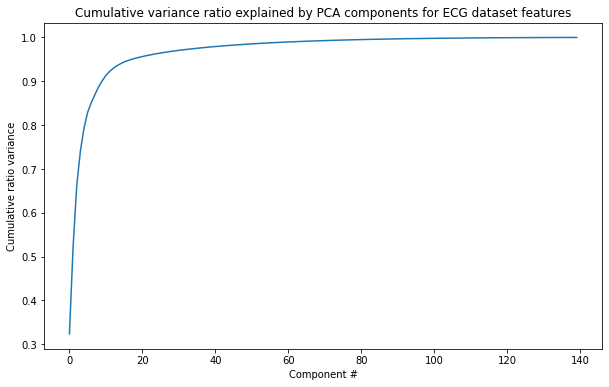

In [67]:
plt.subplots(figsize=(10, 6))
plt.plot(ecg_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for ECG dataset features');

The first twenty components seem to account for over 95%.

Apply the transformation to the data to obtain the derived features.

In [68]:
ecg_pca_x = ecg_pca.transform(ecg_data_scaled_df)

In [69]:
ecg_pca_x.shape

(4998, 140)

#### 3.5.1.4 Creat a dataset of PCA <a id='3.5.1.4_Creat_a_dataset_of_PCA'></a>

At this point, We extract column names and target variable from ECG dataframe and the first twenty principle components from an array. Then, a new DataFrame will be created.

In [70]:
#Create a dataframe containing the values of the first twenty PCA components
type(ecg_pca_x[:,0:20])
pca_df = pd.DataFrame(ecg_pca_x[:,0:20])
pca_df= pca_df.join(data_target)
pca_df.columns = ['PC'+str(i+1) for i in range(20)]+['Target']
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Target
0,-6.185202,-3.704068,0.019498,2.433992,1.150570,1.863981,-0.836926,-0.617475,-1.943941,0.327170,...,-0.561062,-0.559522,-0.732356,0.135028,-0.252167,0.471511,0.105435,-0.216185,-0.336129,1.0
1,-1.963728,-6.467970,5.357860,-4.254247,-0.549525,-0.105415,-0.533237,-0.784654,-1.107883,0.277330,...,0.079851,-0.407070,-0.207363,0.148072,-0.184424,0.185765,-0.294604,-0.250085,0.395619,1.0
2,-5.708907,-4.116847,-0.385621,-2.425069,1.745234,0.961642,0.050830,-0.809492,-0.973347,0.438404,...,0.641473,-0.314558,-0.088770,-0.022059,-0.035812,0.380934,0.613653,0.000317,-0.862835,1.0
3,-5.503168,-3.101418,-0.391432,-2.080076,-1.064035,0.088963,-0.701611,-0.821583,1.554274,0.411431,...,0.706883,-0.525327,-0.173977,0.668557,-0.139761,0.399194,-0.175116,-0.470781,0.176440,1.0
4,-7.978924,-0.653685,-0.558573,2.200700,-0.200398,1.900665,0.391228,0.049154,0.764749,-0.506286,...,0.240476,-0.582129,-1.297155,0.565246,-0.262679,0.123986,0.666461,0.137234,-0.157232,1.0


### 3.5.2 ECG DataFrame Numeric Data<a id='3.5.2_DataFrame_Resort_Numeric_Data'></a>



#### 3.5.2.1 Feature correlation heatmap<a id='3.5.5.2_Feature_correlation_heatmap'></a>

A great way to gain a high level view of relationships amongst the features.

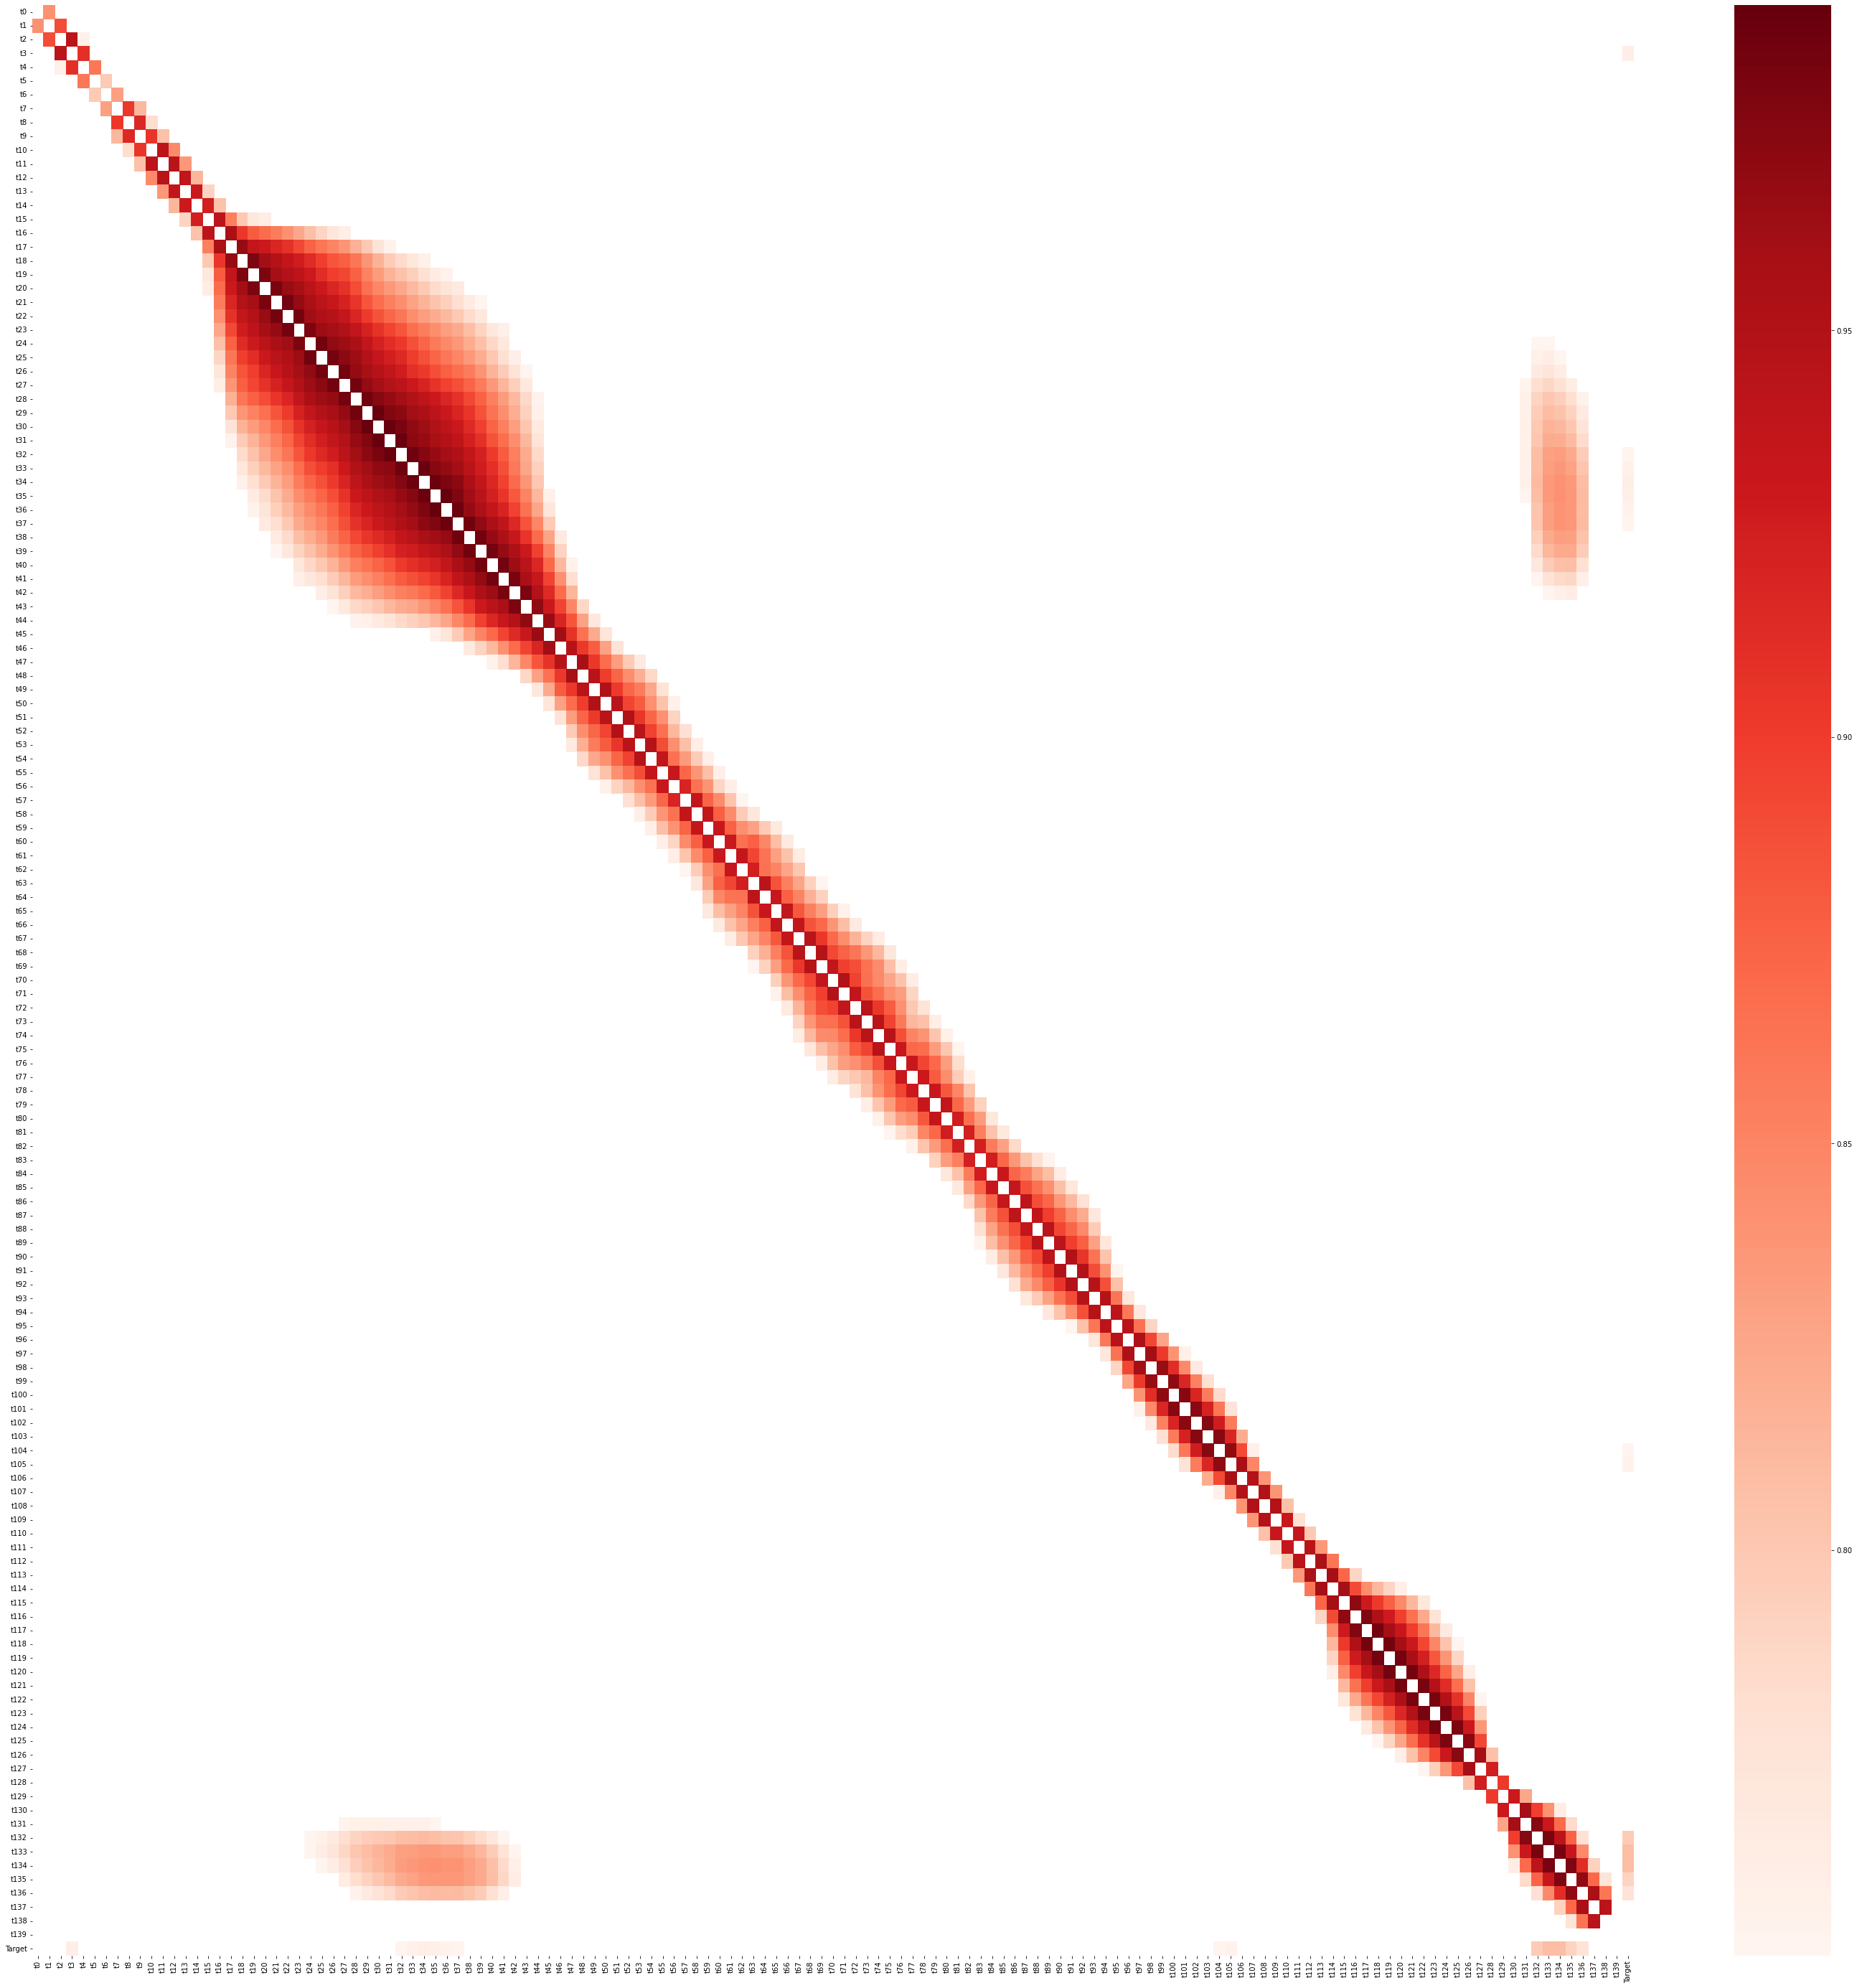

In [71]:
# create correlation matrix with abs values
corr_matrix = ecg_data.corr().abs()

# change this value as needed, if 0.75 does not work for your scenario
threshold = 0.75

filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)] 

plt.figure(figsize=(50,50))
sns.heatmap(filtered_corr_df,  cmap="Reds")
plt.show()

In [72]:
corr_matrix = ecg_data.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

print(sol.where(sol> 0.75))



t35  t36     0.990006
t31  t32     0.988592
t30  t31     0.988467
t29  t30     0.988313
t34  t35     0.988061
               ...   
t18  t120         NaN
t24  t122         NaN
t48  t90          NaN
t67  t90          NaN
t59  t101         NaN
Length: 9870, dtype: float64


#### 3.5.2.3 Scatterplots of numeric features against Traget<a id='3.5.5.3_Scatterplots_of_numeric_features_against_ticket_price'></a>

Correlations, particularly viewing them together as a heatmap, can be a great first pass at identifying patterns. But correlation can mask relationships between two variables. You'll now create a series of scatterplots to really dive into how ticket price varies with other numeric features.

In [73]:
# define useful function to create scatterplots of ticket prices against desired columns
def scatterplots(columns, ncol=None, figsize=(50, 50)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Target', data=ecg_data, alpha=0.5)
        ax.set(xlabel=col, ylabel='Target')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [74]:
features = [x for x in ecg_data.columns if x not in [ 'Target']]
print(features)

['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20', 't21', 't22', 't23', 't24', 't25', 't26', 't27', 't28', 't29', 't30', 't31', 't32', 't33', 't34', 't35', 't36', 't37', 't38', 't39', 't40', 't41', 't42', 't43', 't44', 't45', 't46', 't47', 't48', 't49', 't50', 't51', 't52', 't53', 't54', 't55', 't56', 't57', 't58', 't59', 't60', 't61', 't62', 't63', 't64', 't65', 't66', 't67', 't68', 't69', 't70', 't71', 't72', 't73', 't74', 't75', 't76', 't77', 't78', 't79', 't80', 't81', 't82', 't83', 't84', 't85', 't86', 't87', 't88', 't89', 't90', 't91', 't92', 't93', 't94', 't95', 't96', 't97', 't98', 't99', 't100', 't101', 't102', 't103', 't104', 't105', 't106', 't107', 't108', 't109', 't110', 't111', 't112', 't113', 't114', 't115', 't116', 't117', 't118', 't119', 't120', 't121', 't122', 't123', 't124', 't125', 't126', 't127', 't128', 't129', 't130', 't131', 't132', 't133', 't134', 't135', 't136', 't137', 't138

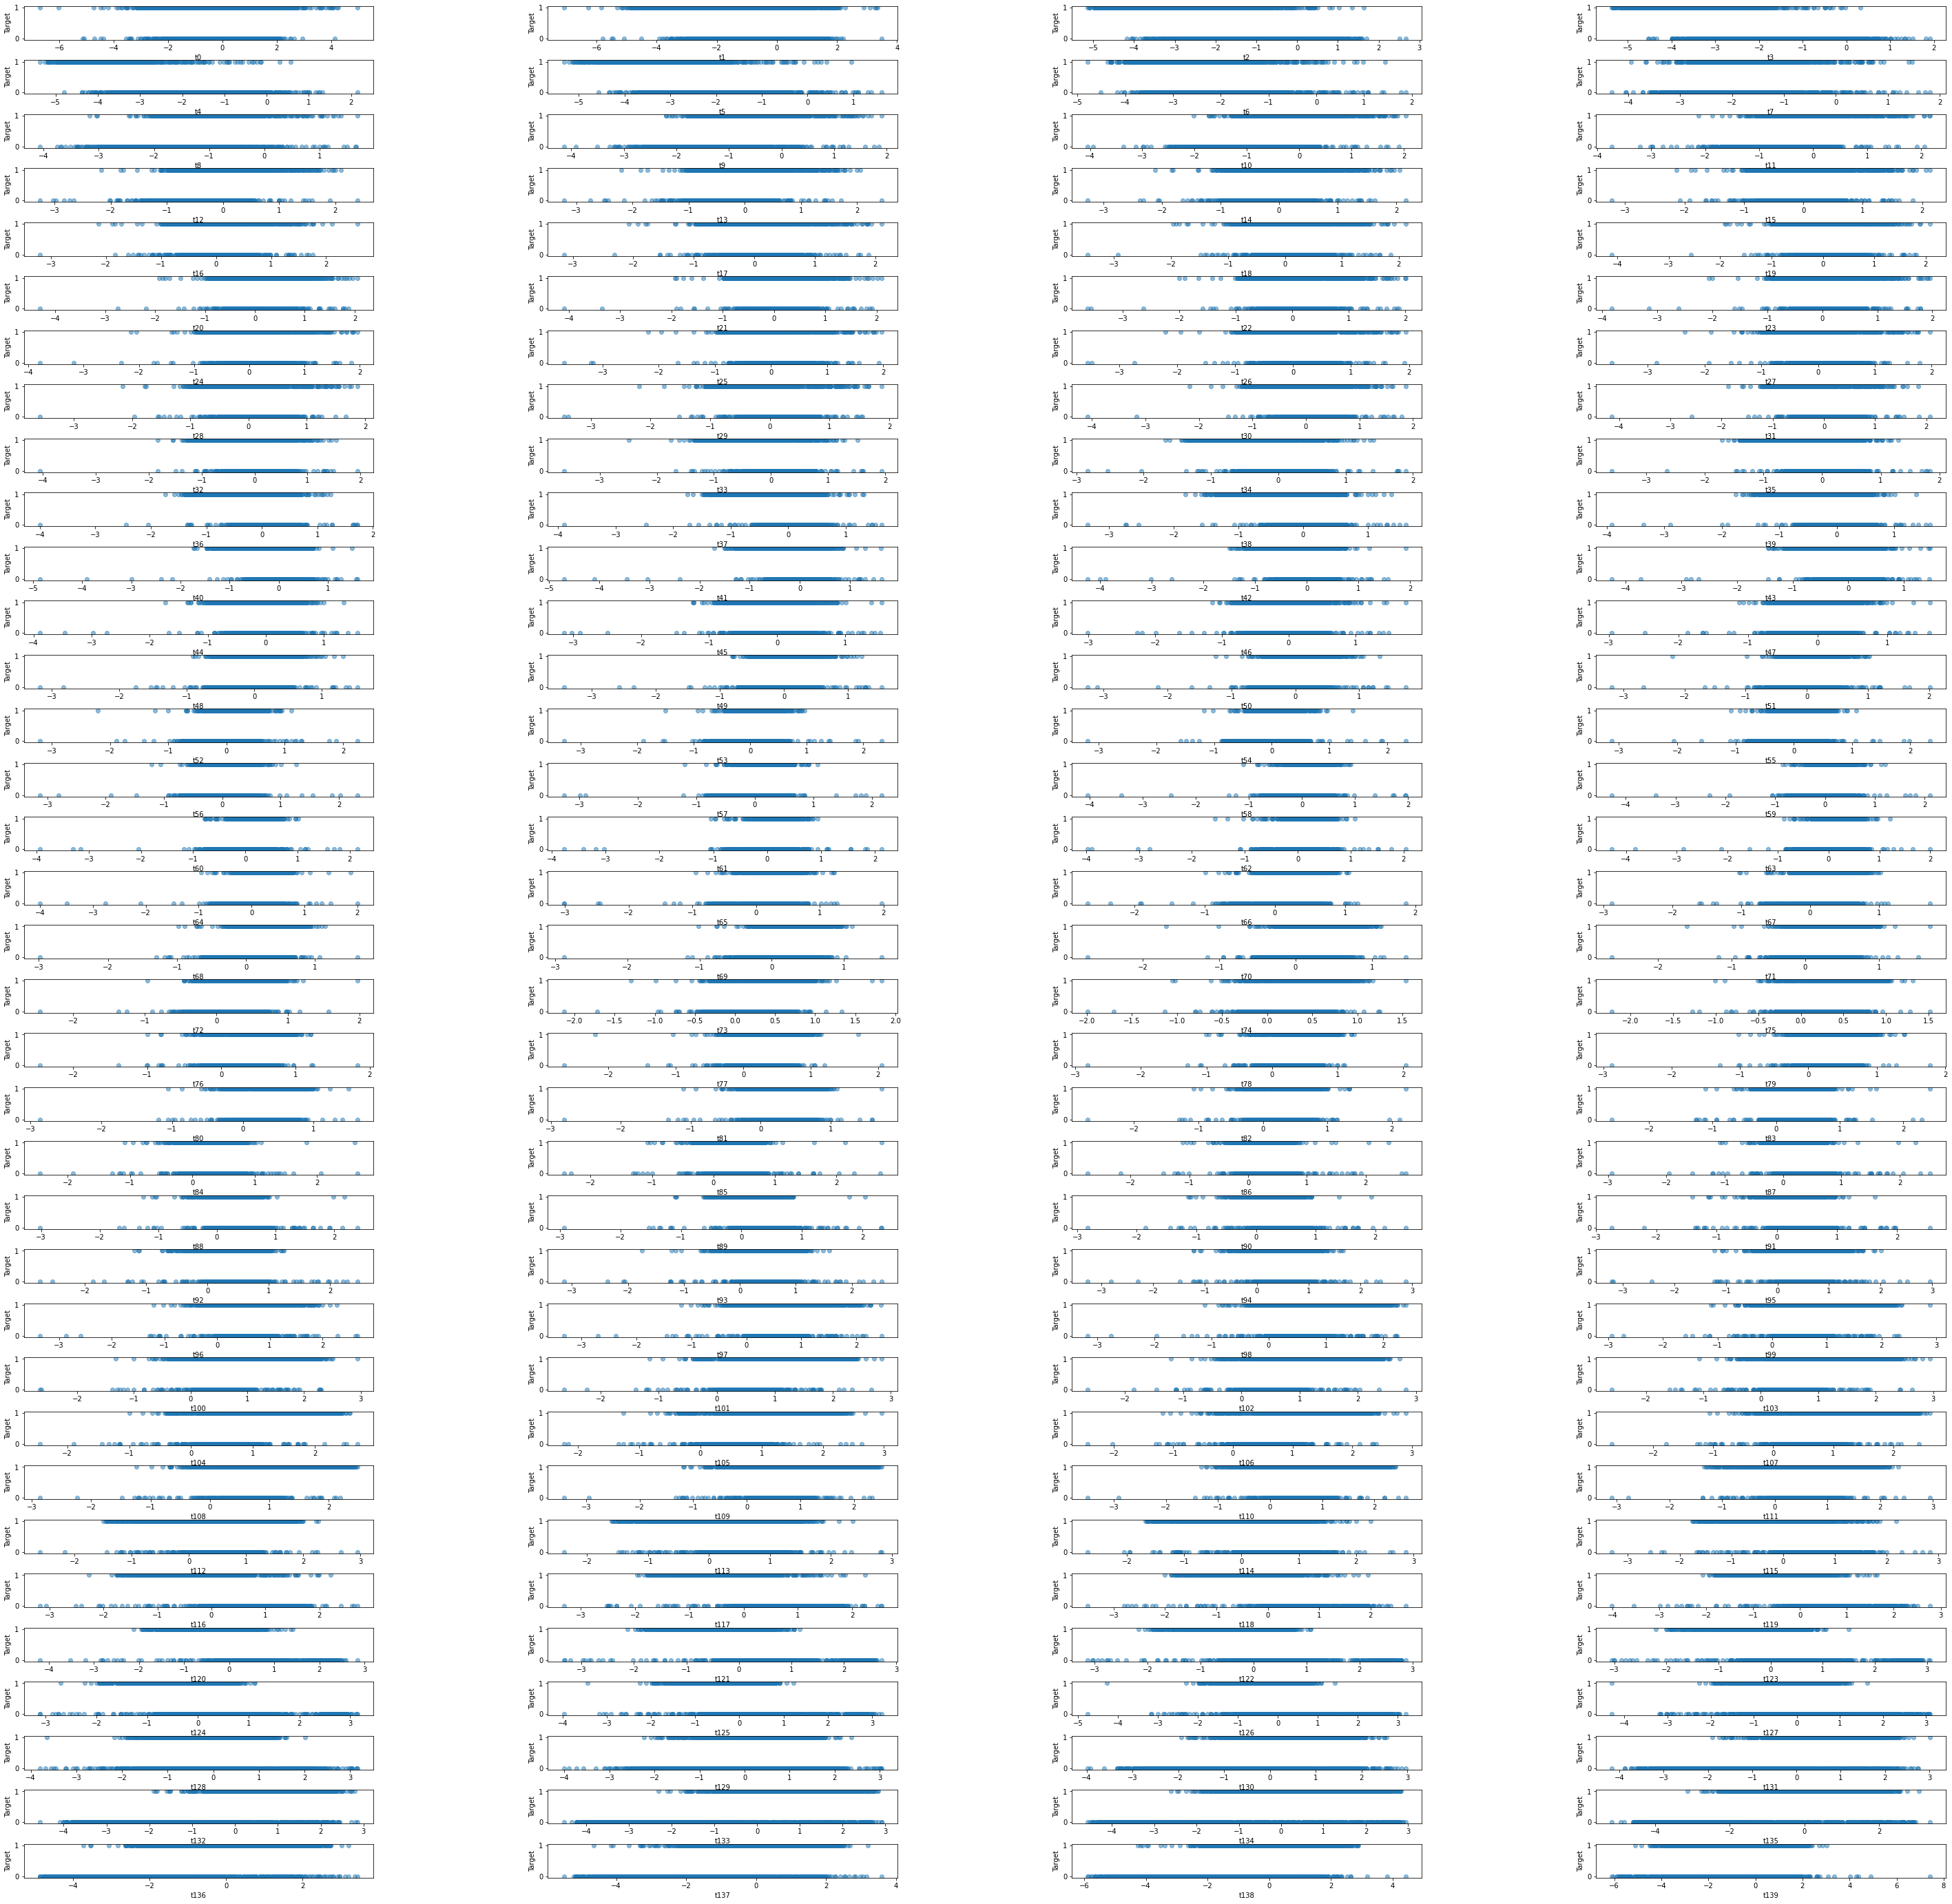

In [75]:
scatterplots(features, ncol=4, figsize=(50, 50))

In [76]:
# Save the data 

datapath = '../data'
save_file(ecg_data, 'ecg_data_step3_features.csv', datapath)

A file already exists with this name.

Writing file.  "../data\ecg_data_step3_features.csv"
